In [1]:
import sys
sys.path
sys.path.append('/home/nishadgothoskar/bayes3d')

In [2]:
import numpy as np
import jax.numpy as jnp
import jax
import bayes3d as b
import time
from PIL import Image
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import cv2
import trimesh
import os
import glob
import bayes3d.neural
import pickle
# Can be helpful for debugging:
# jax.config.update('jax_enable_checks', True) 
# from bayes3d.neural.segmentation import carvekit_get_foreground_mask
import genjax
import bayes3d.genjax

In [3]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [4]:
importance_jit = jax.jit(b.genjax.model.importance)
key = jax.random.PRNGKey(10)

In [58]:
all_data = pickle.load(open("tutorial_real_data.pkl", "rb"))
# all_data = pickle.load(open("./09-12-2023-13:53:46.pkl", "rb"))
IDX = 0
data = all_data[IDX]

dict_keys(['rgbPixels', 'depthPixels', 'segmentationMaskBuffer', 'camera_pose', 'camera_matrix'])


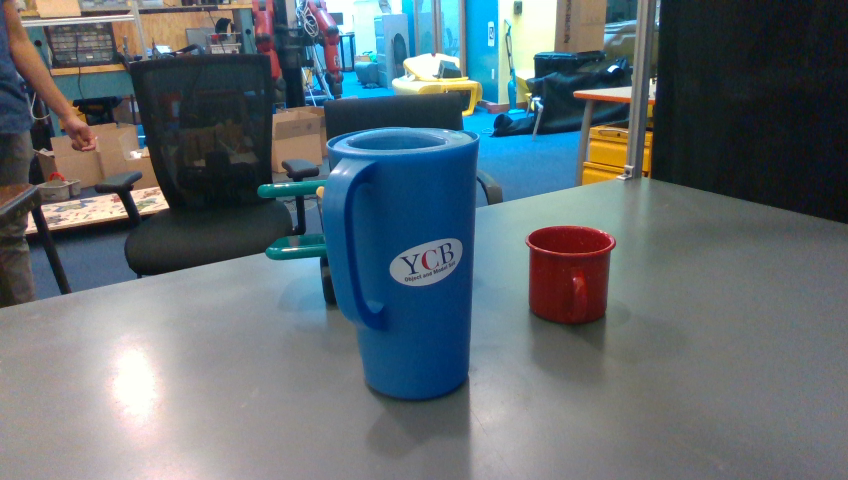

In [59]:
print(data["camera_image"].keys())
K = data["camera_image"]['camera_matrix'][0]
rgb = data["camera_image"]['rgbPixels']
depth = data["camera_image"]['depthPixels']
camera_pose = data["camera_image"]['camera_pose']
camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
h,w = depth.shape
near = 0.001
rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
b.get_rgb_image(rgbd_original.rgb)

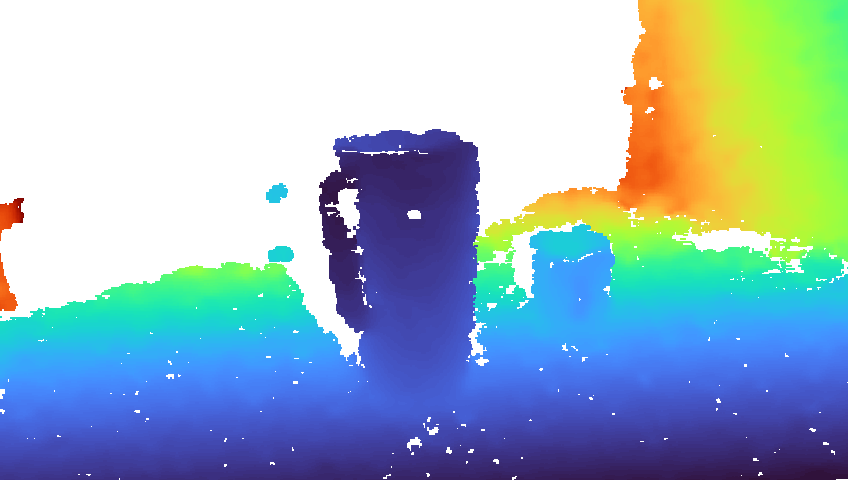

In [7]:
b.get_depth_image(rgbd_original.depth,max_val=1.5)

In [8]:
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)

In [9]:
table_pose, plane_dims = b.utils.infer_table_plane(
    b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics),
    jnp.eye(4), rgbd_scaled_down.intrinsics, 
    ransac_threshold=0.001, inlier_threshold=0.001, segmentation_threshold=0.1
)

In [10]:
b.clear_visualizer()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))
b.show_pose("table", table_pose)

In [11]:
b.setup_renderer(rgbd_scaled_down.intrinsics)
# b.RENDERER.add_mesh_from_file("toy_plane.ply")
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(10+1).rjust(6, '0') + ".ply")
b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)
b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (192, 96, 1024)


In [12]:
width = 0.03
ang = jnp.pi
num_position_grids = 51
num_angle_grids = 51
contact_param_deltas = b.utils.make_translation_grid_enumeration_3d(
    -width, -width, -ang,
    width, width, ang,
    num_position_grids,num_position_grids,num_angle_grids
)

grid_params = [
    (0.5, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)), (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)),
    (0.02, jnp.pi, (9,9,51))
    , (0.01, jnp.pi/5, (15,15,15)),
      (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

OBJECT_NUMBER = 1
address = f"contact_params_{OBJECT_NUMBER}"
enumerators = b.genjax.make_enumerator([address])

def c2f_(potential_trace, contact_param_gridding_schedule):
    cp = potential_trace[address]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = enumerators.enumerate_choices_get_scores(potential_trace, key, cps)
        cp = cps[scores.argmax()]
    potential_trace = enumerators.update_choices(potential_trace, key, cp)
    return potential_trace, scores.argmax()
c2f = jax.jit(c2f_)

In [56]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)
trace, weight = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(2),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": obs_img,
    "variance": 0.03,
    "outlier_prob": 0.0001,
    "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(1),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-12.0, -12.0, -22*jnp.pi]), jnp.array([12.0, 12.0, 22*jnp.pi])]),
    b.RENDERER.model_box_dims)
)
print(trace.get_score())
b.genjax.viz_trace_meshcat(trace)

-45.66136


In [57]:
key = jax.random.split(key,2)[0]
low, high = jnp.array([-0.4, -0.4, -jnp.pi]), jnp.array([0.4, 0.4, jnp.pi])
potential_trace = b.genjax.add_object_jit(trace, key, 1, 0, 2,3)
sampled_cp = jax.random.uniform(key, shape=(3,),minval=low, maxval=high)
print(sampled_cp)
potential_trace = b.genjax.update_address(potential_trace, key, address, sampled_cp)
b.genjax.viz_trace_meshcat(potential_trace)

[ 0.23003963 -0.38300046  2.8630178 ]


In [16]:
import time
cp = potential_trace[address]
new_potential_trace = potential_trace
for cp_grid in contact_param_gridding_schedule:
    cps = cp + cp_grid
    scores = enumerators.enumerate_choices_get_scores(new_potential_trace, key, cps)
    cp = cps[scores.argmax()]
    new_potential_trace = enumerators.update_choices(new_potential_trace, key, cp)
    b.genjax.viz_trace_meshcat(new_potential_trace)
    time.sleep(0.5)

In [38]:
%%time
key = jax.random.split(key,2)[0]
new_potential_trace = c2f(potential_trace, contact_param_gridding_schedule)[0]
print(new_potential_trace["contact_params_1"])
b.genjax.viz_trace_meshcat(new_potential_trace)

[0.10350819 0.08779351 1.7163045 ]
CPU times: user 8.78 s, sys: 123 ms, total: 8.91 s
Wall time: 7.76 s


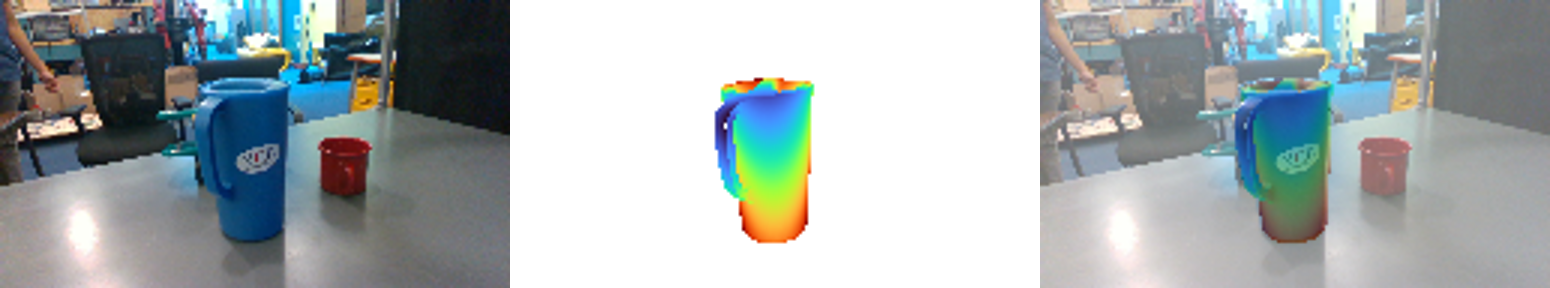

In [24]:
scaling_factor = 3.0
img = b.scale_image(b.get_depth_image(
    b.genjax.get_rendered_image(new_potential_trace)[...,2],
), scaling_factor)
rgb = b.scale_image(b.get_rgb_image(
    rgbd_scaled_down.rgb
),scaling_factor)

b.hstack_images([rgb, img, b.overlay_image(rgb, img, alpha=0.4)])